## Data preparation

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable

from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer

from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

2023-01-05 08:21:01.444312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Read sequences
sequences = list()
with open(os.path.join('data', 'sequences.txt'), 'r') as f:
    for line in f:
        sequences.append(line[:-1])

# Split data into training and test sets
sequences_train = list()
sequences_test = list()
proteins_test = list()
y_train = list()
with open(os.path.join('data', 'graph_labels.txt'), 'r') as f:
    for i,line in enumerate(f):
        t = line.split(',')
        if len(t[1][:-1]) == 0:
            proteins_test.append(t[0])
            sequences_test.append(sequences[i])
        else:
            sequences_train.append(sequences[i])
            y_train.append(int(t[1][:-1]))

In [3]:
df_train = pd.DataFrame(zip(sequences_train, y_train), columns = ['Sequence', 'Label'])

<AxesSubplot:>

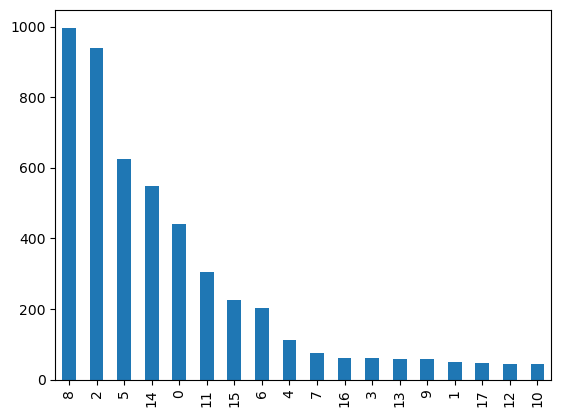

In [4]:
df_train.Label.value_counts().plot(kind='bar')

In [5]:
# Encode Labels
lb = LabelBinarizer()
y_train = lb.fit_transform(df_train['Label'])

# Tokenize Sequence with keras
max_len = 600
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)

# Tokenise Sequence with TFIDF
# vec = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))
# X_train = vec.fit_transform(sequences_train)
# X_test = vec.transform(sequences_test)

X_test = tokenizer.texts_to_sequences(sequences_test)
X_test = pad_sequences(X_test, maxlen=max_len)

# Not real y_test but y_test from initial model
df_test = pd.read_csv('sample_submission/sample_submission_test.csv', sep=',')
y_test = torch.LongTensor(df_test.iloc[:, 1:].to_numpy())


# Deal with last batch size
X_test = np.vstack((X_test, np.zeros((1, max_len))))
X_train = tokenizer.texts_to_sequences(sequences_train)
X_train = pad_sequences(X_train, maxlen=max_len)
print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape, 'y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

X_train shape: (4888, 600) X_test shape: (1224, 600) y_train shape: (4888, 18) y_test shape: torch.Size([1223, 18])


In [6]:
# Create Dataset

class Sequence_Dataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

## Models

In [7]:
# All parameters

vocab_size = len(np.unique(X_train))
sequence_length = max_len
embedding_size = 21
hidden_size = 512
num_classes = 18 # number of different proteins
lr = 0.001
batch_size = 136
dropout = 0.7
n_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name()

# BiLSTM Params
num_layers = 3 # number of layers for BiLTSM model

# CNN Params
n_filters = 300
filter_sizes = [3, 10, 20, 40]

In [8]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, num_classes, batch_size):
        """
        vocab_size: int, number of words in vocbulary
        emedding_size: int, embedding dimension
        hidden_size: int, size of hidden layer
        num_layers: int, number of LSTM layers
        num_classes: number of classes
        batch_size: size of mini batches
        """
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        # self.hidden = self.init_hidden()
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_size*2, 128)
        self.fc2 = nn.Linear(128, num_classes)
  
    def init_hidden(self):
        # initialise hidden & cell state
        h0 = Variable(torch.zeros(self.num_layers*2, self.batch_size, self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers*2, self.batch_size, self.hidden_size)).to(device)
        return (h0, c0)

    def forward(self, inputs, hidden):
        x = self.embedding(inputs) # x=[batch_size, sequence_len, embedding_size]
        # lstm_out, self.hidden = self.lstm(x, self.hidden) # lstm_out=[batch_size, sequence_len, hidden_size]
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.permute(1,0,2) # lstm_out=[sequence_len, batch_size, hidden_size]
        y = self.fc1(lstm_out[-1]) # take last hidden state, y=[batch_size, num_classes]
        y = F.leaky_relu(y, 0.1)
        y = self.dropout(y)
        y = self.fc2(y)
        probs = F.log_softmax(y, dim=1) # probs=[batch_size, num_classes]
        return probs

# generate model instance
bilstm_model = BiLSTM(vocab_size, embedding_size, hidden_size, num_layers, num_classes, batch_size).to(device)
print(bilstm_model)

BiLSTM(
  (embedding): Embedding(22, 21)
  (lstm): LSTM(21, 512, num_layers=3, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=18, bias=True)
)


In [9]:

class CNN(nn.Module):
    """
    vocab_size: int, number of words in vocbulary
    emedding_size: int, embedding dimension
    hidden_size: int, size of hidden layer
    n_filters: int, number of filters to use per conv layer
    filter_sizes: list(int), list of conv filter sizes
    batch_size: size of mini batches
    """
    def __init__(self, vocab_size, embedding_size, hidden_size, n_filters, filter_sizes, num_classes):
        super(CNN, self).__init__()        
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_size)) for fs in filter_sizes]).to(device)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(len(filter_sizes)*n_filters, hidden_size, bias=True)  
        self.fc2 = nn.Linear(hidden_size, num_classes, bias=True)

    def forward(self, inputs):
        x = self.embedding(inputs) # x=[batch_size, seq_len, embedding_size]
        x = x.unsqueeze(1) # x=[batch_size, 1, seq_len, embedding_size]  
        conv_out = [F.relu(conv(x)).squeeze(3) for conv in self.convs] # conv_n = [batch size, n_filters, seq_len - filter_sizes[n]]
        pool_out = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conv_out] # pool_n = [batch size, n_filters]
        cat = self.dropout(torch.cat(pool_out, dim = 1)) # cat = [batch size, len(filter_sizes)*n_filters]
        y = self.fc1(F.relu(cat))
        y = self.dropout(y)
        y = self.fc2(y)
        probs = F.log_softmax(y, dim=1) # probs=[batch_size, num_classes]
        return probs

cnn_model = CNN(vocab_size, embedding_size, hidden_size, n_filters, filter_sizes, num_classes).to(device)
print(cnn_model)

CNN(
  (embedding): Embedding(22, 21)
  (convs): ModuleList(
    (0): Conv2d(1, 300, kernel_size=(3, 21), stride=(1, 1))
    (1): Conv2d(1, 300, kernel_size=(10, 21), stride=(1, 1))
    (2): Conv2d(1, 300, kernel_size=(20, 21), stride=(1, 1))
    (3): Conv2d(1, 300, kernel_size=(40, 21), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=18, bias=True)
)


In [10]:
class CNN_BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, n_filters, filter_sizes, num_layers, num_classes, batch_size, dropout):
        """
        vocab_size: int, number of words in vocbulary
        emedding_size: int, embedding dimension
        hidden_size: int, size of hidden layer
        num_layers: int, number of LSTM layers
        num_classes: number of classes
        batch_size: size of mini batches
        """
        super(CNN_BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_size)) for fs in filter_sizes]).to(device)

        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        l = n_filters*len(filter_sizes) + hidden_size*2
        self.fc1 = nn.Linear(l, l//2)
        self.fc2 = nn.Linear(l//2, num_classes)
  
    def init_hidden(self):
        # initialise hidden & cell state
        h0 = Variable(torch.zeros(self.num_layers*2, self.batch_size, self.hidden_size)).to(device)
        c0 = Variable(torch.zeros(self.num_layers*2, self.batch_size, self.hidden_size)).to(device)
        return (h0, c0)

    def forward(self, inputs, hidden):
        x = self.embedding(inputs) # x=[batch_size, seq_len, embedding_size]

        cnn_x = x.unsqueeze(1) # x=[batch_size, 1, seq_len, embedding_size]  
        cnn_x = [F.relu(conv(cnn_x)).squeeze(3) for conv in self.convs] # conv_n = [batch size, n_filters, seq_len - filter_sizes[n]]
        cnn_x = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in cnn_x]
        cnn_out = self.dropout(torch.cat(cnn_x, dim = 1))

        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.permute(1,0,2) # lstm_out=[sequence_len, batch_size, hidden_size] because batch_first = True
        # feature extraction 1 using maxpool1d over all states
        # lstm_out = th.transpose(lstm_out, 0, 1)
        # lstm_out = th.transpose(lstm_out, 1, 2)
        # lstm_out = F.max_pool1d(lstm_out, lstm_out.size(2)).squeeze(2)
        # feature extraction 2 taking last hidden state
        lstm_out = lstm_out[-1]
        lstm_out = F.relu(lstm_out)

        # concatenate CNN and LSTM output before FC layers
        cnn_out = torch.transpose(cnn_out, 0, 1)
        lstm_out = torch.transpose(lstm_out, 0, 1)
        cnn_lstm_out = torch.cat((cnn_out, lstm_out), 0)
        cnn_lstm_out = torch.transpose(cnn_lstm_out, 0, 1)

        # FC layers
        y = F.relu(cnn_lstm_out)
        y = self.fc1(y)
        y = self.dropout(y)
        y = F.relu(y)
        y = self.fc2(y)
        probs = F.log_softmax(y, dim=1) # probs=[batch_size, num_classes]
        return probs

# generate model instance
# cnnbilstm_model = CNN_BiLSTM(vocab_size, embedding_size, hidden_size, n_filters, filter_sizes, num_layers, num_classes, batch_size).to(device)
# print(cnnbilstm_model)
     

## Training

In [11]:
# Batch training loop
def train(dataloader, model, optimizer, criterion, pred_func):
    """
    Main function for training LSTM model and printing prompt
    """
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 11
    start_time = time.time()

    for idx, (batch, label) in enumerate(dataloader):
        batch, label = batch.to(device), label.to(device)
        model.zero_grad()
        model, pred = pred_func(model, batch)
        label = torch.argmax(label, 1) # one_hot --> indexing
        loss = criterion(pred, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (pred.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader), total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()



def append_metrics(history, metrics):
    """ append metrics dictionary to history dictionary """
    for key in metrics.keys():
        history[key].append(metrics[key])
    return history

def LSTM_pred(model, batch):
    """ LSTM initialisation and prediction for training loop """
    hidden = model.init_hidden() # initalise hidden states
    pred = model(batch, hidden)
    return model, pred

def CNN_pred(model, batch):
    """ CNN prediction for taining loop """
    pred = model(batch)
    return model, pred

In [12]:
train_set = Sequence_Dataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
#model = BiLSTM(vocab_size, embedding_size, hidden_size, num_layers, num_classes, batch_size).to(device)
model = CNN_BiLSTM(vocab_size, embedding_size, hidden_size, n_filters, filter_sizes, num_layers, num_classes, batch_size, dropout).to(device)
pred_func = LSTM_pred
name = model.__class__.__name__ # model name

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1., gamma=0.1)


In [13]:
for epoch in range(1, n_epochs+ 1):

    # train
    train(train_loader, model, optimizer, criterion, pred_func)
    # evaluate
    #train_metrics = evaluate(train_generator, model, criterion, pred_func)
    # log history
    #train_hist = append_metrics(train_hist, train_metrics)
    # save model
torch.save({'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()},
        os.path.join('Model_save', name +'_'+ str(epoch) +'_7.pt'))
    # update accuracy for each epoch

| epoch   1 |    11/   35 batches | accuracy    0.162
| epoch   1 |    22/   35 batches | accuracy    0.172
| epoch   1 |    33/   35 batches | accuracy    0.200
| epoch   2 |    11/   35 batches | accuracy    0.206
| epoch   2 |    22/   35 batches | accuracy    0.209
| epoch   2 |    33/   35 batches | accuracy    0.219
| epoch   3 |    11/   35 batches | accuracy    0.256
| epoch   3 |    22/   35 batches | accuracy    0.258
| epoch   3 |    33/   35 batches | accuracy    0.285
| epoch   4 |    11/   35 batches | accuracy    0.278
| epoch   4 |    22/   35 batches | accuracy    0.258
| epoch   4 |    33/   35 batches | accuracy    0.269
| epoch   5 |    11/   35 batches | accuracy    0.274
| epoch   5 |    22/   35 batches | accuracy    0.307
| epoch   5 |    33/   35 batches | accuracy    0.314
| epoch   6 |    11/   35 batches | accuracy    0.326
| epoch   6 |    22/   35 batches | accuracy    0.318
| epoch   6 |    33/   35 batches | accuracy    0.307
| epoch   7 |    11/   35 ba

In [14]:
# Evaluate model
def evaluate(dataloader, model, criterion, pred_func):
    model.eval()
    y_pred_proba = list()
    
    with torch.no_grad():
        tot_acc, tot_count = 0, 0
        for idx, batch in enumerate(dataloader):
            batch = batch.to(device)
            _ , pred = pred_func(model, batch)
            y_pred_proba.append(pred)
    y_pred_proba = torch.cat(y_pred_proba, dim=0)  
    y_pred_proba = torch.exp(y_pred_proba)
    return y_pred_proba



# Write predictions to a file
test_dataloader = DataLoader(dataset=torch.LongTensor(X_test), batch_size=batch_size, drop_last=True)
y_pred_proba = evaluate(test_dataloader, model, criterion, pred_func)[:-1]

with open('sample_submission/sample_submission_CNN_BiLSTM_10.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(18):
        lst.append('class'+str(i))
    lst.insert(0, "name")
    writer.writerow(lst)
    for i, protein in enumerate(proteins_test):
        lst = y_pred_proba[i,:].tolist()
        lst.insert(0, protein)
        writer.writerow(lst)
    print(lst)


['6qmn', 1.4313704355117807e-07, 1.784120702737202e-12, 1.3535021992083784e-09, 3.048105838843185e-07, 2.2147023770457963e-08, 1.1026561423932435e-06, 1.9625827007985208e-07, 3.3099814000792094e-09, 0.9999974966049194, 4.5327566700059663e-10, 6.2931966304802245e-09, 1.551747619288335e-09, 7.931713445763489e-12, 7.176720941970416e-07, 8.163706155528416e-09, 7.367943061220572e-12, 1.2006333705016914e-09, 5.810391612293131e-10]


In [48]:
#print(y_pred_proba[0], torch.argmin(y_pred_proba[0]))

args_max = y_pred_proba.argmax(1)
r = F.one_hot(args_max, num_classes = 18)
print(r.size())

torch.Size([1087, 18])


In [3]:
res_pred = pd.read_csv('sample_submission_BiLSTM.csv', sep=',')

In [34]:
print(type(y_pred_proba))

<class 'torch.Tensor'>
